*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 5 - Compressing Data via Dimensionality Reduction

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -p numpy,scipy,matplotlib,sklearn

Author: Sebastian Raschka

Last updated: 2022-04-09

numpy     : 1.21.2
scipy     : 1.7.1
matplotlib: 3.4.2
sklearn   : 1.0.2



*The use of `watermark` is optional. You can install this Jupyter extension via*  

    conda install watermark -c conda-forge  

or  

    pip install watermark   

*For more information, please see: https://github.com/rasbt/watermark.*

<br>
<br>

### Overview

- [Unsupervised dimensionality reduction via principal component analysis 128](#Unsupervised-dimensionality-reduction-via-principal-component-analysis-128)
  - [The main steps behind principal component analysis](#The-main-steps-behind-principal-component-analysis)
  - [Extracting the principal components step-by-step](#Extracting-the-principal-components-step-by-step)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Principal component analysis versus linear discriminant analysis](#Principal-component-analysis-versus-linear-discriminant-analysis)
  - [The inner workings of linear discriminant analysis](#The-inner-workings-of-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting examples onto the new feature space](#Projecting-examples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Using kernel principal component analysis for nonlinear mappings](#Using-kernel-principal-component-analysis-for-nonlinear-mappings)
  - [Kernel functions and the kernel trick](#Kernel-functions-and-the-kernel-trick)
  - [Implementing a kernel principal component analysis in Python](#Implementing-a-kernel-principal-component-analysis-in-Python)
    - [Example 1 – separating half-moon shapes](#Example-1:-Separating-half-moon-shapes)
    - [Example 2 – separating concentric circles](#Example-2:-Separating-concentric-circles)
  - [Projecting new data points](#Projecting-new-data-points)
  - [Kernel principal component analysis in scikit-learn](#Kernel-principal-component-analysis-in-scikit-learn)
- [Summary](#Summary)

<br>
<br>

In [2]:
from IPython.display import Image
%matplotlib inline

# Unsupervised dimensionality reduction via principal component analysis

## The main steps behind principal component analysis

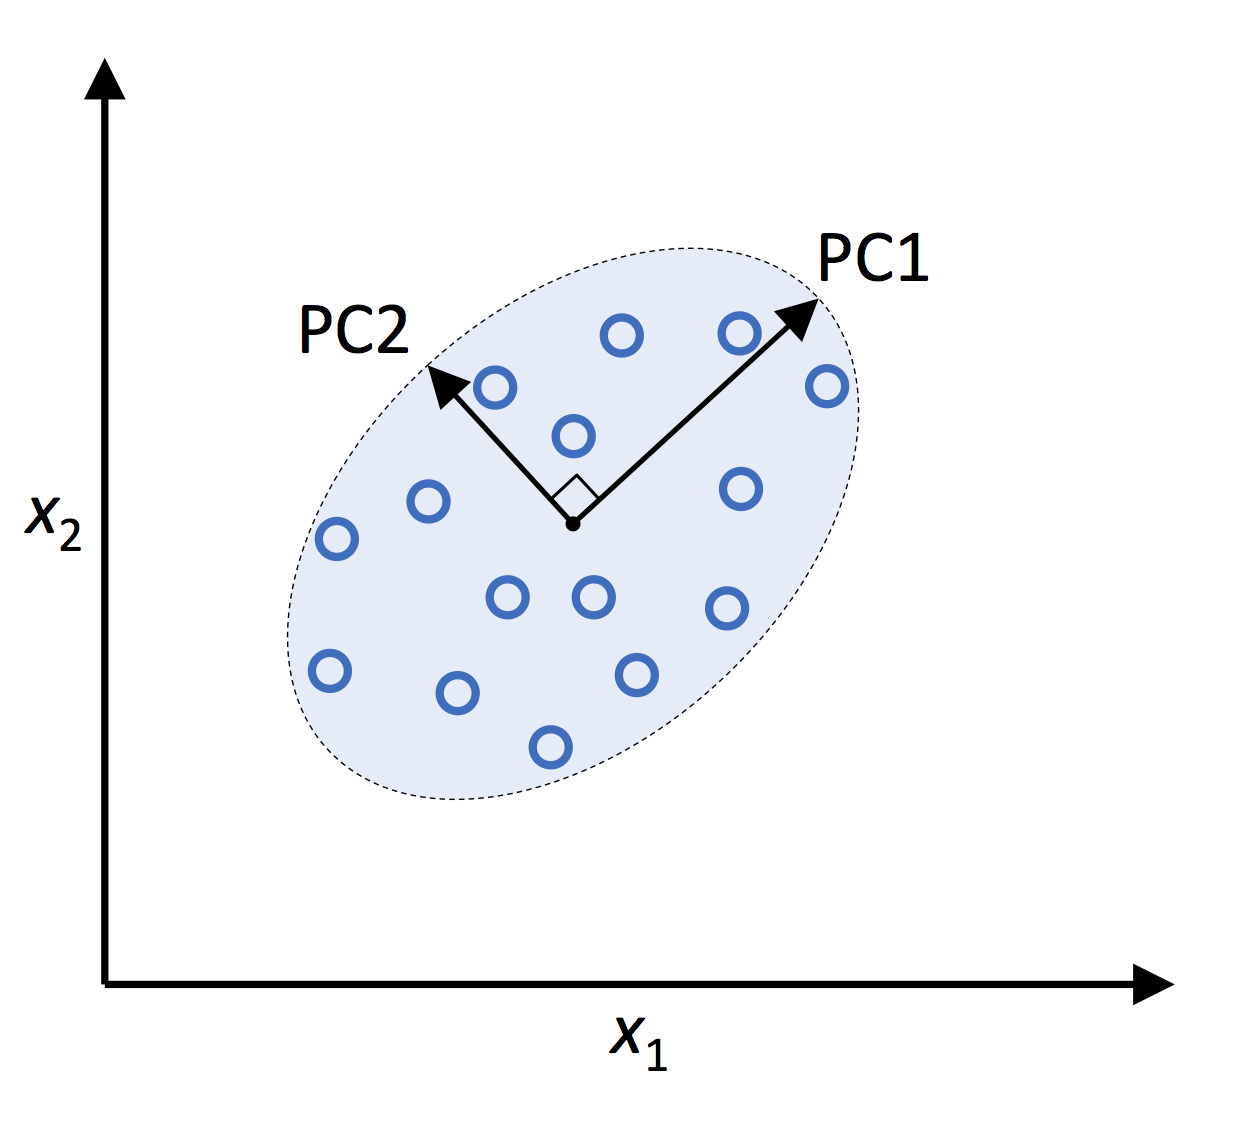

In [3]:
Image(filename='images/05_01.png', width=400) 

$$ x = \left[x_{1}, x_{2},...,x_{d} \right] \ \ x \in R^{d} $$

which is then transformed by a transformation matrix, 𝑾 ∈ $ R^{d \times k}$ :

$$xW = z$$

$$ z = \left[z_{1}, z_{2},...,z_{k} \right] \ \ z \in R^{k} $$

## Extracting the principal components step-by-step

In [4]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

Splitting the data into 70% training and 30% test subsets.

In [5]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standardizing the data.

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Note**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 examples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify examples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these examples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify examples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- example5: -18.37 -> class 2
- example6: -17.15 -> class 2
- example7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new examples" are much lower than every standardized feature in the training set.

---

Eigendecomposition of the covariance matrix.

In [7]:
import numpy as np
cov_mat = np.cov(X_train_std.T) # 記得轉置
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [8]:
eigen_vecs # 注意 eigenvector 的方向，是由上到下。

array([[-1.37242175e-01,  5.03034778e-01, -1.37748734e-01,
        -3.29610003e-03, -2.90625226e-01,  2.99096847e-01,
         7.90529293e-02, -3.68176414e-01, -3.98377017e-01,
        -9.44869777e-02,  3.74638877e-01, -1.27834515e-01,
         2.62834263e-01],
       [ 2.47243265e-01,  1.64871190e-01,  9.61503863e-02,
         5.62646692e-01,  8.95378697e-02,  6.27036396e-01,
        -2.74002014e-01, -1.25775752e-02,  1.10458230e-01,
         2.63652406e-02, -1.37405597e-01,  8.06401578e-02,
        -2.66769211e-01],
       [-2.54515927e-02,  2.44564761e-01,  6.77775667e-01,
        -1.08977111e-01, -1.60834991e-01,  3.89128239e-04,
         1.32328045e-01,  1.77578177e-01,  3.82496856e-01,
         1.42747511e-01,  4.61583035e-01,  1.67924873e-02,
        -1.15542548e-01],
       [ 2.06945084e-01, -1.13529045e-01,  6.25040550e-01,
         3.38187002e-02,  5.15873402e-02, -4.05836452e-02,
         2.23999097e-01, -4.40592110e-01, -2.43373853e-01,
        -1.30485780e-01, -4.18953989e

In [9]:
np.cov?

In [10]:
np.linalg.eig?

**Note**: 

Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


<br>
<br>

## Total and explained variance

In [11]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

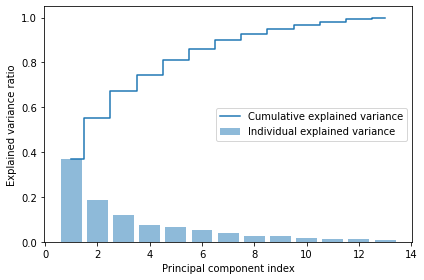

In [12]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

<br>
<br>

## Feature transformation

In [13]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [14]:
eigen_pairs

[(4.842745315655895,
  array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
         -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
         -0.32613263, -0.36861022, -0.29669651])),
 (2.4160245870352255,
  array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
          0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
         -0.20716433, -0.24902536,  0.38022942])),
 (1.5484582488203509,
  array([-0.13774873,  0.09615039,  0.67777567,  0.62504055,  0.19613548,
          0.14031057,  0.11705386,  0.13121778,  0.0304309 , -0.07992997,
          0.05305915,  0.13239103, -0.07065022])),
 (0.9612043774977367,
  array([-0.0032961 ,  0.56264669, -0.10897711,  0.0338187 , -0.36751107,
          0.24024513,  0.1870533 , -0.02292622,  0.49626233,  0.10648294,
         -0.36905375,  0.14201609, -0.16768217])),
 (0.8416616104578425,
  array([-0.29062523,  0.08953787, -0.16083499,  0.05158734,  0.67648707,
         -0.11851114,

In [15]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [16]:
eigen_pairs[0][1].shape

(13,)

In [17]:
eigen_pairs[0][1][:,np.newaxis]

array([[-0.13724218],
       [ 0.24724326],
       [-0.02545159],
       [ 0.20694508],
       [-0.15436582],
       [-0.39376952],
       [-0.41735106],
       [ 0.30572896],
       [-0.30668347],
       [ 0.07554066],
       [-0.32613263],
       [-0.36861022],
       [-0.29669651]])

In [18]:
eigen_vecs[:,:2]

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

**Note**
Depending on which version of NumPy and LAPACK you are using, you may obtain the Matrix W with its signs flipped. Please note that this is not an issue: If $v$ is an eigenvector of a matrix $\Sigma$, we have

$$\Sigma v = \lambda v,$$

where $\lambda$ is our eigenvalue,


then $-v$ is also an eigenvector that has the same eigenvalue, since
$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

In [19]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

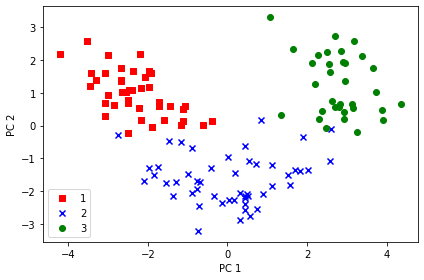

In [20]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

<br>
<br>

## Principal component analysis in scikit-learn

**NOTE**

The following four code cells has been added in addition to the content to the book, to illustrate how to replicate the results from our own PCA implementation in scikit-learn:

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [22]:
X_train_pca

array([[ 2.38299011,  0.45458499, -0.22703207, ...,  0.29726982,
         0.23489704, -0.40161994],
       [-1.96578183,  1.65376939,  1.38709268, ..., -0.14334855,
        -0.27213429, -0.0148829 ],
       [-2.53907598,  1.02909066,  1.32551841, ..., -0.15739501,
         0.64563779,  0.13835572],
       ...,
       [ 4.35308397,  0.66536041, -1.31737358, ..., -0.09152939,
         0.37706503,  0.38561142],
       [-1.84315373, -1.50688415,  0.24631395, ..., -0.17323527,
         0.86394227, -1.00559686],
       [-0.40860955, -1.29720607,  1.40315602, ...,  0.46153523,
         0.1071608 , -0.09379872]])

In [23]:
X_train_pca.shape

(124, 13)

In [24]:
pca.fit_transform?

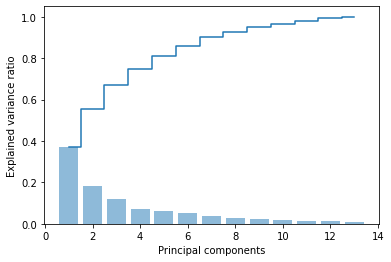

In [25]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [26]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

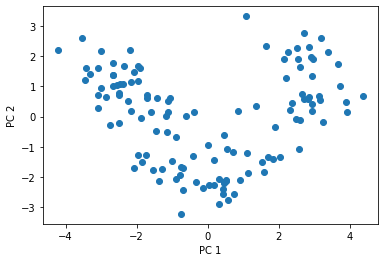

In [27]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [102]:
pca.explained_variance_

array([4.8427, 2.416 ])

In [28]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

Training logistic regression classifier using the first 2 principal components.

In [29]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

<ipython-input-28-1a9a60ddae7a>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


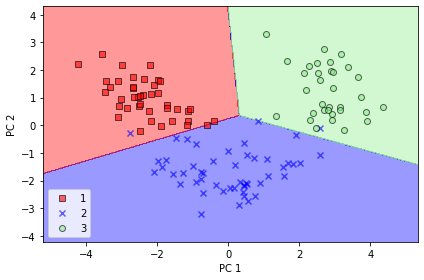

In [30]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

<ipython-input-28-1a9a60ddae7a>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


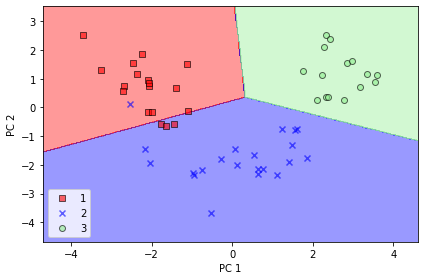

In [31]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

In [32]:
y_train_pca_pred = lr.predict(X_train_pca)
print("Missclassified samples: %d" % (y_train != y_train_pca_pred).sum())

Missclassified samples: 2


In [33]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.2f" % accuracy_score(y_train, y_train_pca_pred))

Accuracy: 0.98


In [34]:
y_test_pca_pred = lr.predict(X_test_pca)
print("Missclassified samples: %d" % (y_test != y_test_pca_pred).sum())

Missclassified samples: 4


In [35]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.2f" % accuracy_score(y_test, y_test_pca_pred))

Accuracy: 0.93


---

In [36]:
lr = lr.fit(X_train_std, y_train)
y_train_pred = lr.predict(X_train_std)
print("Missclassified samples: %d" % (y_train != y_train_pred).sum())

Missclassified samples: 0


In [37]:
print("Accuracy: %.2f" % accuracy_score(y_train, y_train_pred))

Accuracy: 1.00


In [38]:
y_test_pred = lr.predict(X_test_std)
print("Missclassified samples: %d" % (y_test != y_test_pred).sum())

Missclassified samples: 0


In [39]:
print("Accuracy: %.2f" % accuracy_score(y_test, y_test_pred))

Accuracy: 1.00


<br>
<br>

# Supervised data compression via linear discriminant analysis

## Principal component analysis versus linear discriminant analysis

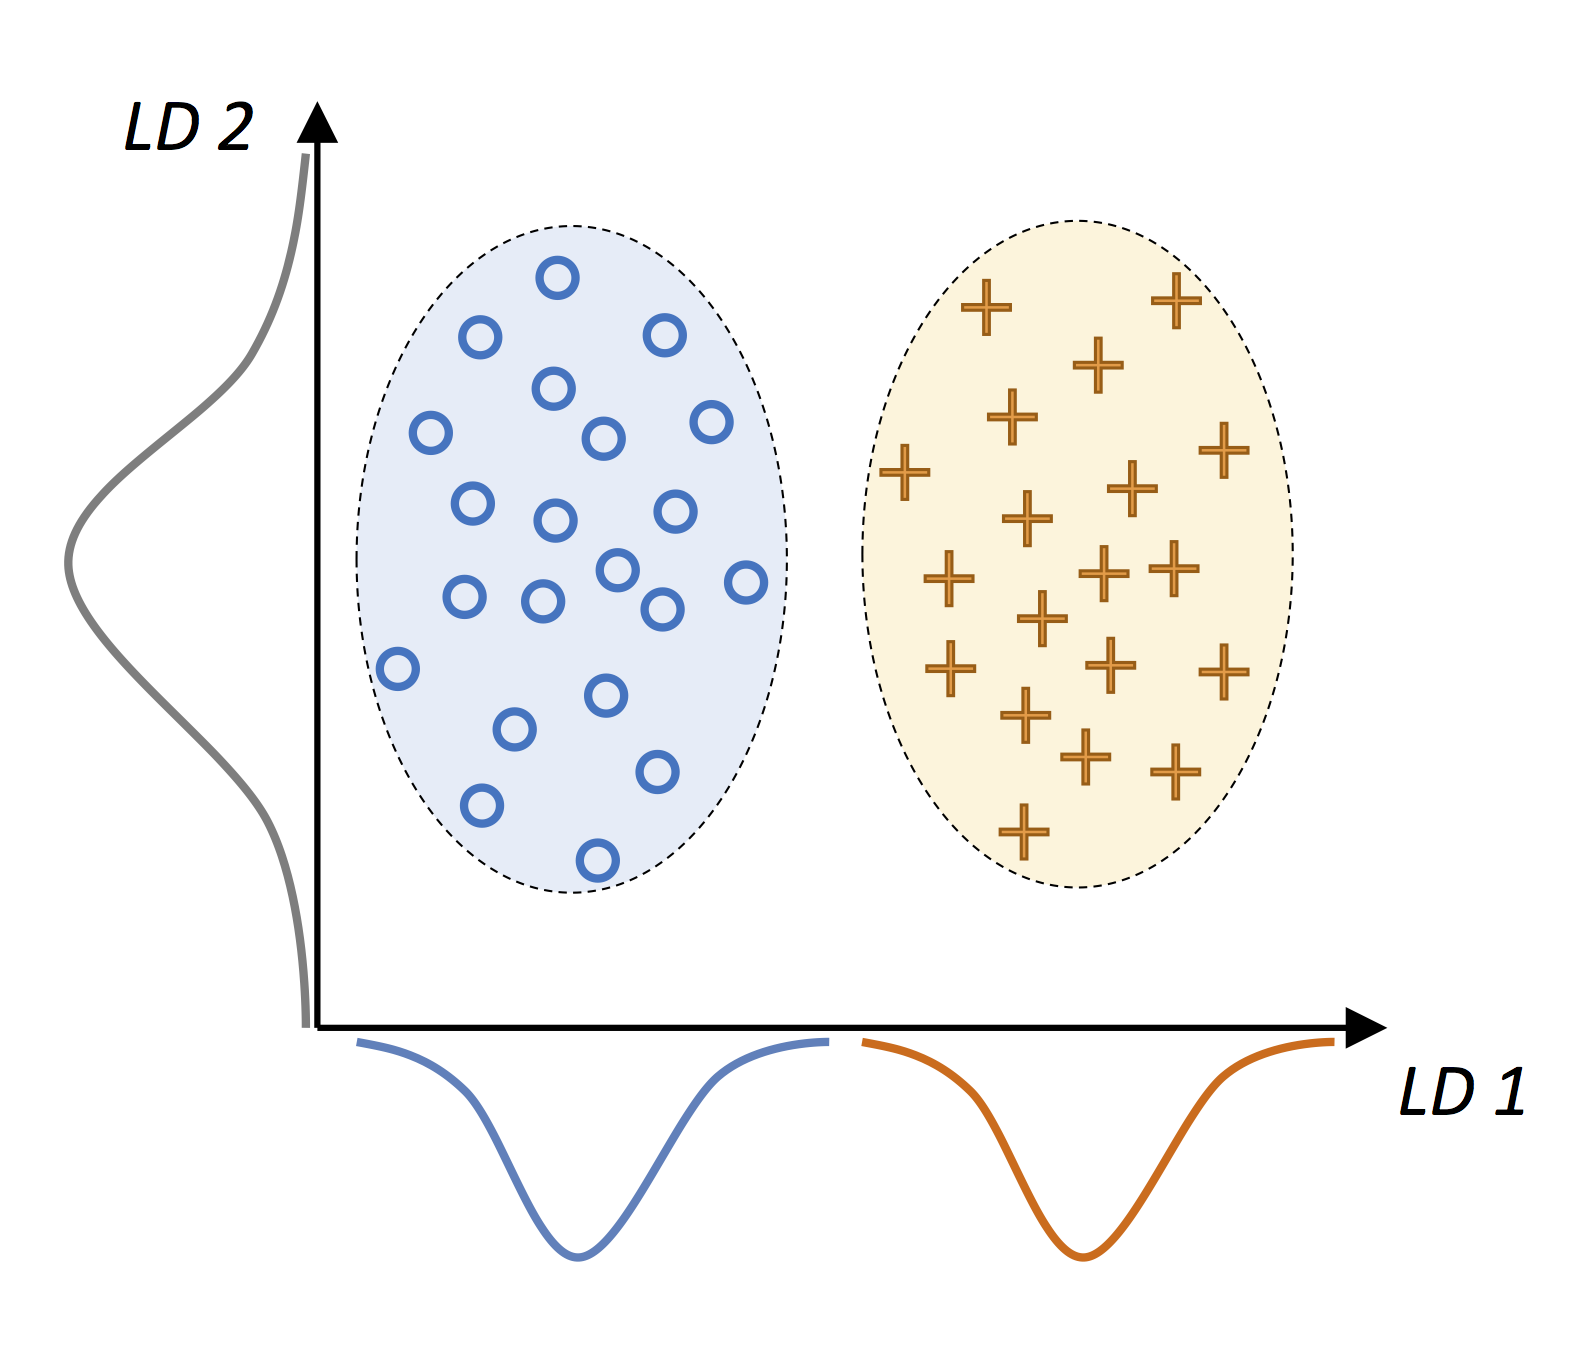

In [40]:
Image(filename='images/05_06.png', width=400) 

## The inner workings of linear discriminant analysis

<br>
<br>

## Computing the scatter matrices

Calculate the mean vectors for each class:

In [41]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Compute the within-class scatter matrix:

$$S_{w} = \sum_{i=1}^{c}S_{i}$$

$$S_{i} = \sum_{x\in D_{i}}(x-m_{i})(x-m_{i})^{T}$$

In [42]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [43]:
S_W

array([[ 5.0722e+01,  3.1007e+00, -7.9323e+00, -5.7848e+00, -2.8879e+00,
         7.8990e+00,  2.4543e+00,  9.3932e-01,  9.0781e-01,  1.5486e+01,
         7.0293e+00, -1.8659e+00,  4.9370e+00],
       [ 3.1007e+00,  9.0179e+01,  4.7074e+00,  1.4750e+01, -1.0900e+01,
        -8.8059e-02,  9.7797e-01,  8.4547e+00,  4.4732e+00, -1.4494e+01,
        -2.0361e+01,  3.5876e+00, -1.1176e+01],
       [-7.9323e+00,  4.7074e+00,  1.1189e+02,  7.0126e+01,  2.2213e+01,
         1.5505e+01,  1.4856e+01,  2.0454e+01, -2.3344e+00,  1.3787e+00,
         5.6585e+00,  8.1917e+00,  3.2570e-01],
       [-5.7848e+00,  1.4750e+01,  7.0126e+01,  9.2147e+01,  1.2485e+01,
         6.2091e+00,  6.2783e+00,  1.2735e+01, -4.7597e+00, -4.1511e+00,
         1.1779e+00,  1.1633e+01, -4.5296e+00],
       [-2.8879e+00, -1.0900e+01,  2.2213e+01,  1.2485e+01,  1.0605e+02,
         1.0950e+01,  5.2875e+00, -2.1136e+01,  1.3076e+01,  5.9930e+00,
         8.4568e+00, -5.3128e-01,  1.1845e+01],
       [ 7.8990e+00, -8.8059e-

Better: covariance matrix since classes are not equally distributed:

In [44]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


$$\Sigma_{i} = \frac{1}{n_{i}} S_{i} = \frac{1}{n_{i}}\sum_{x\in D_{i}}(x-m_{i})(x-m_{i})^{T}$$

In [45]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [46]:
S_W

array([[ 1.2448,  0.0967, -0.1276, -0.1105, -0.0726,  0.2374,  0.0753,
         0.0231,  0.1102,  0.4261,  0.1411, -0.0155,  0.1224],
       [ 0.0967,  2.2666,  0.1168,  0.3517, -0.2622, -0.0467, -0.0186,
         0.2194,  0.0187, -0.3939, -0.4167,  0.0787, -0.2492],
       [-0.1276,  0.1168,  2.6024,  1.6442,  0.5364,  0.3947,  0.3191,
         0.4553, -0.0353,  0.06  ,  0.167 ,  0.1987, -0.0081],
       [-0.1105,  0.3517,  1.6442,  2.1604,  0.325 ,  0.1535,  0.1222,
         0.273 , -0.0824, -0.068 ,  0.0336,  0.2548, -0.1201],
       [-0.0726, -0.2622,  0.5364,  0.325 ,  2.4397,  0.2384,  0.1433,
        -0.5166,  0.2566,  0.1445,  0.1777, -0.0058,  0.2509],
       [ 0.2374, -0.0467,  0.3947,  0.1535,  0.2384,  1.352 ,  0.6416,
        -0.0781,  0.7644,  0.4392,  0.0177,  0.4359,  0.1554],
       [ 0.0753, -0.0186,  0.3191,  0.1222,  0.1433,  0.6416,  0.6968,
        -0.2588,  0.5765,  0.3851, -0.0408,  0.2525,  0.0748],
       [ 0.0231,  0.2194,  0.4553,  0.273 , -0.5166, -0.0781, 

Compute the between-class scatter matrix:

$$S_{B} = \sum_{i=1}^{c}n_{i}(m_{i} - m)(m_{i} - m)^{T}$$

In [47]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [48]:
S_B

array([[ 73.2779,   5.1521,  29.3409, -37.8053,  35.3288,  27.8688,
         24.4037, -10.917 ,  11.9293,  51.2816,   0.2198,  -0.3445,
         73.9711],
       [  5.1521,  33.8209,   5.5342,  17.6688,  -3.0595, -41.4067,
        -51.4514,  32.9397, -31.0444,  36.0237, -47.4845, -53.4785,
        -18.4551],
       [ 29.3409,   5.5342,  12.1084, -13.0286,  13.5707,   6.6597,
          4.2554,  -0.8742,   1.4687,  23.8967,  -4.84  ,  -5.6837,
         27.1642],
       [-37.8053,  17.6688, -13.0286,  31.8532, -21.5944, -40.7237,
        -44.8903,  26.1101, -25.5242,  -6.7623, -28.9705, -32.2968,
        -52.5343],
       [ 35.3288,  -3.0595,  13.5707, -21.5944,  17.9512,  20.621 ,
         20.5742, -10.8479,  11.0338,  19.3529,   7.9757,   8.6902,
         39.5823],
       [ 27.8688, -41.4067,   6.6597, -40.7237,  20.621 ,  66.8061,
         78.1916, -47.8401,  45.861 , -22.5142,  61.6487,  69.1515,
         58.7931],
       [ 24.4037, -51.4514,   4.2554, -44.8903,  20.5742,  78.1916,
  

<br>
<br>

## Selecting linear discriminants for the new feature subspace

Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [49]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [50]:
eigen_vals

array([ 5.6843e-14+0.0000e+00j,  1.7276e+02+0.0000e+00j,
        3.4962e+02+0.0000e+00j, -2.1456e-14+1.3210e-14j,
       -2.1456e-14-1.3210e-14j,  1.5994e-14+5.6000e-15j,
        1.5994e-14-5.6000e-15j,  9.7572e-15+7.0622e-15j,
        9.7572e-15-7.0622e-15j, -6.9697e-17+8.1301e-15j,
       -6.9697e-17-8.1301e-15j, -1.0227e-14+0.0000e+00j,
       -6.3548e-15+0.0000e+00j])

In [51]:
eigen_vecs

array([[ 0.7517+0.j    , -0.4092+0.j    , -0.1481+0.j    ,
         0.1069-0.321j ,  0.1069+0.321j , -0.0146-0.1217j,
        -0.0146+0.1217j, -0.2716+0.2222j, -0.2716-0.2222j,
        -0.2785-0.1256j, -0.2785+0.1256j, -0.031 +0.j    ,
        -0.0519+0.j    ],
       [-0.0834+0.j    , -0.1577+0.j    ,  0.0908+0.j    ,
         0.5056+0.j    ,  0.5056-0.j    ,  0.1404-0.2043j,
         0.1404+0.2043j, -0.1507-0.0082j, -0.1507+0.0082j,
        -0.0197-0.1347j, -0.0197+0.1347j, -0.498 +0.j    ,
         0.4236+0.j    ],
       [-0.2406+0.j    , -0.3537+0.j    , -0.0168+0.j    ,
        -0.0923+0.1756j, -0.0923-0.1756j,  0.5307+0.j    ,
         0.5307-0.j    , -0.1089-0.1894j, -0.1089+0.1894j,
         0.6034+0.j    ,  0.6034-0.j    ,  0.0812+0.j    ,
         0.0133+0.j    ],
       [ 0.2515+0.j    ,  0.3223+0.j    ,  0.1484+0.j    ,
        -0.0248-0.1574j, -0.0248+0.1574j,  0.0663-0.1649j,
         0.0663+0.1649j, -0.2495+0.3043j, -0.2495-0.3043j,
         0.1753-0.0225j,  0.1753+0.02

**Note**:
    
Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


Sort eigenvectors in descending order of the eigenvalues:

In [52]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979388
5.684341886080802e-14
2.519711684621208e-14
2.519711684621208e-14
1.6945741194028736e-14
1.6945741194028736e-14
1.2044805863936269e-14
1.2044805863936269e-14
1.0226622272648067e-14
8.130405900835131e-15
8.130405900835131e-15
6.3547570701846255e-15


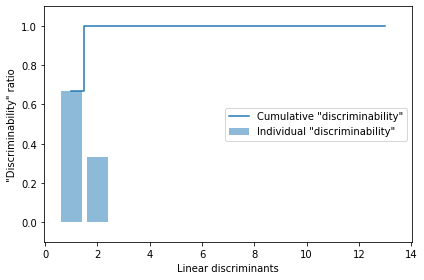

In [53]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_07.png', dpi=300)
plt.show()

In [54]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


<br>
<br>

## Projecting examples onto the new feature space

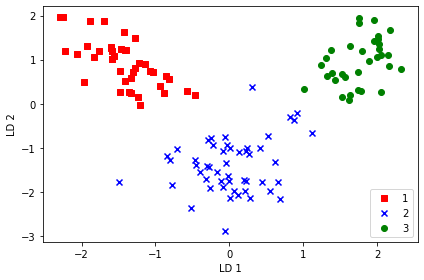

In [55]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/05_08.png', dpi=300)
plt.show()

<br>
<br>

## LDA via scikit-learn

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

<ipython-input-28-1a9a60ddae7a>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


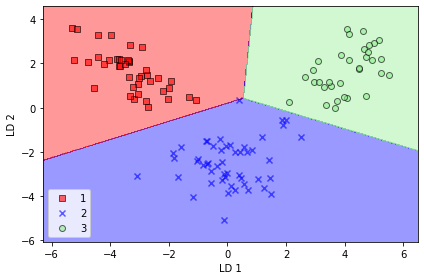

In [57]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()

<ipython-input-28-1a9a60ddae7a>:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


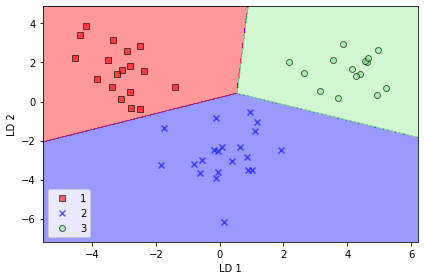

In [58]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_10.png', dpi=300)
plt.show()

In [59]:
y_train_lda_pred = lr.predict(X_train_lda)
print("Missclassified samples: %d" % (y_train != y_train_lda_pred).sum())

Missclassified samples: 0


In [60]:
y_test_lda_pred = lr.predict(X_test_lda)
print("Missclassified samples: %d" % (y_test != y_test_lda_pred).sum())

Missclassified samples: 0


<br>
<br>

# Using kernel principal component analysis for nonlinear mappings

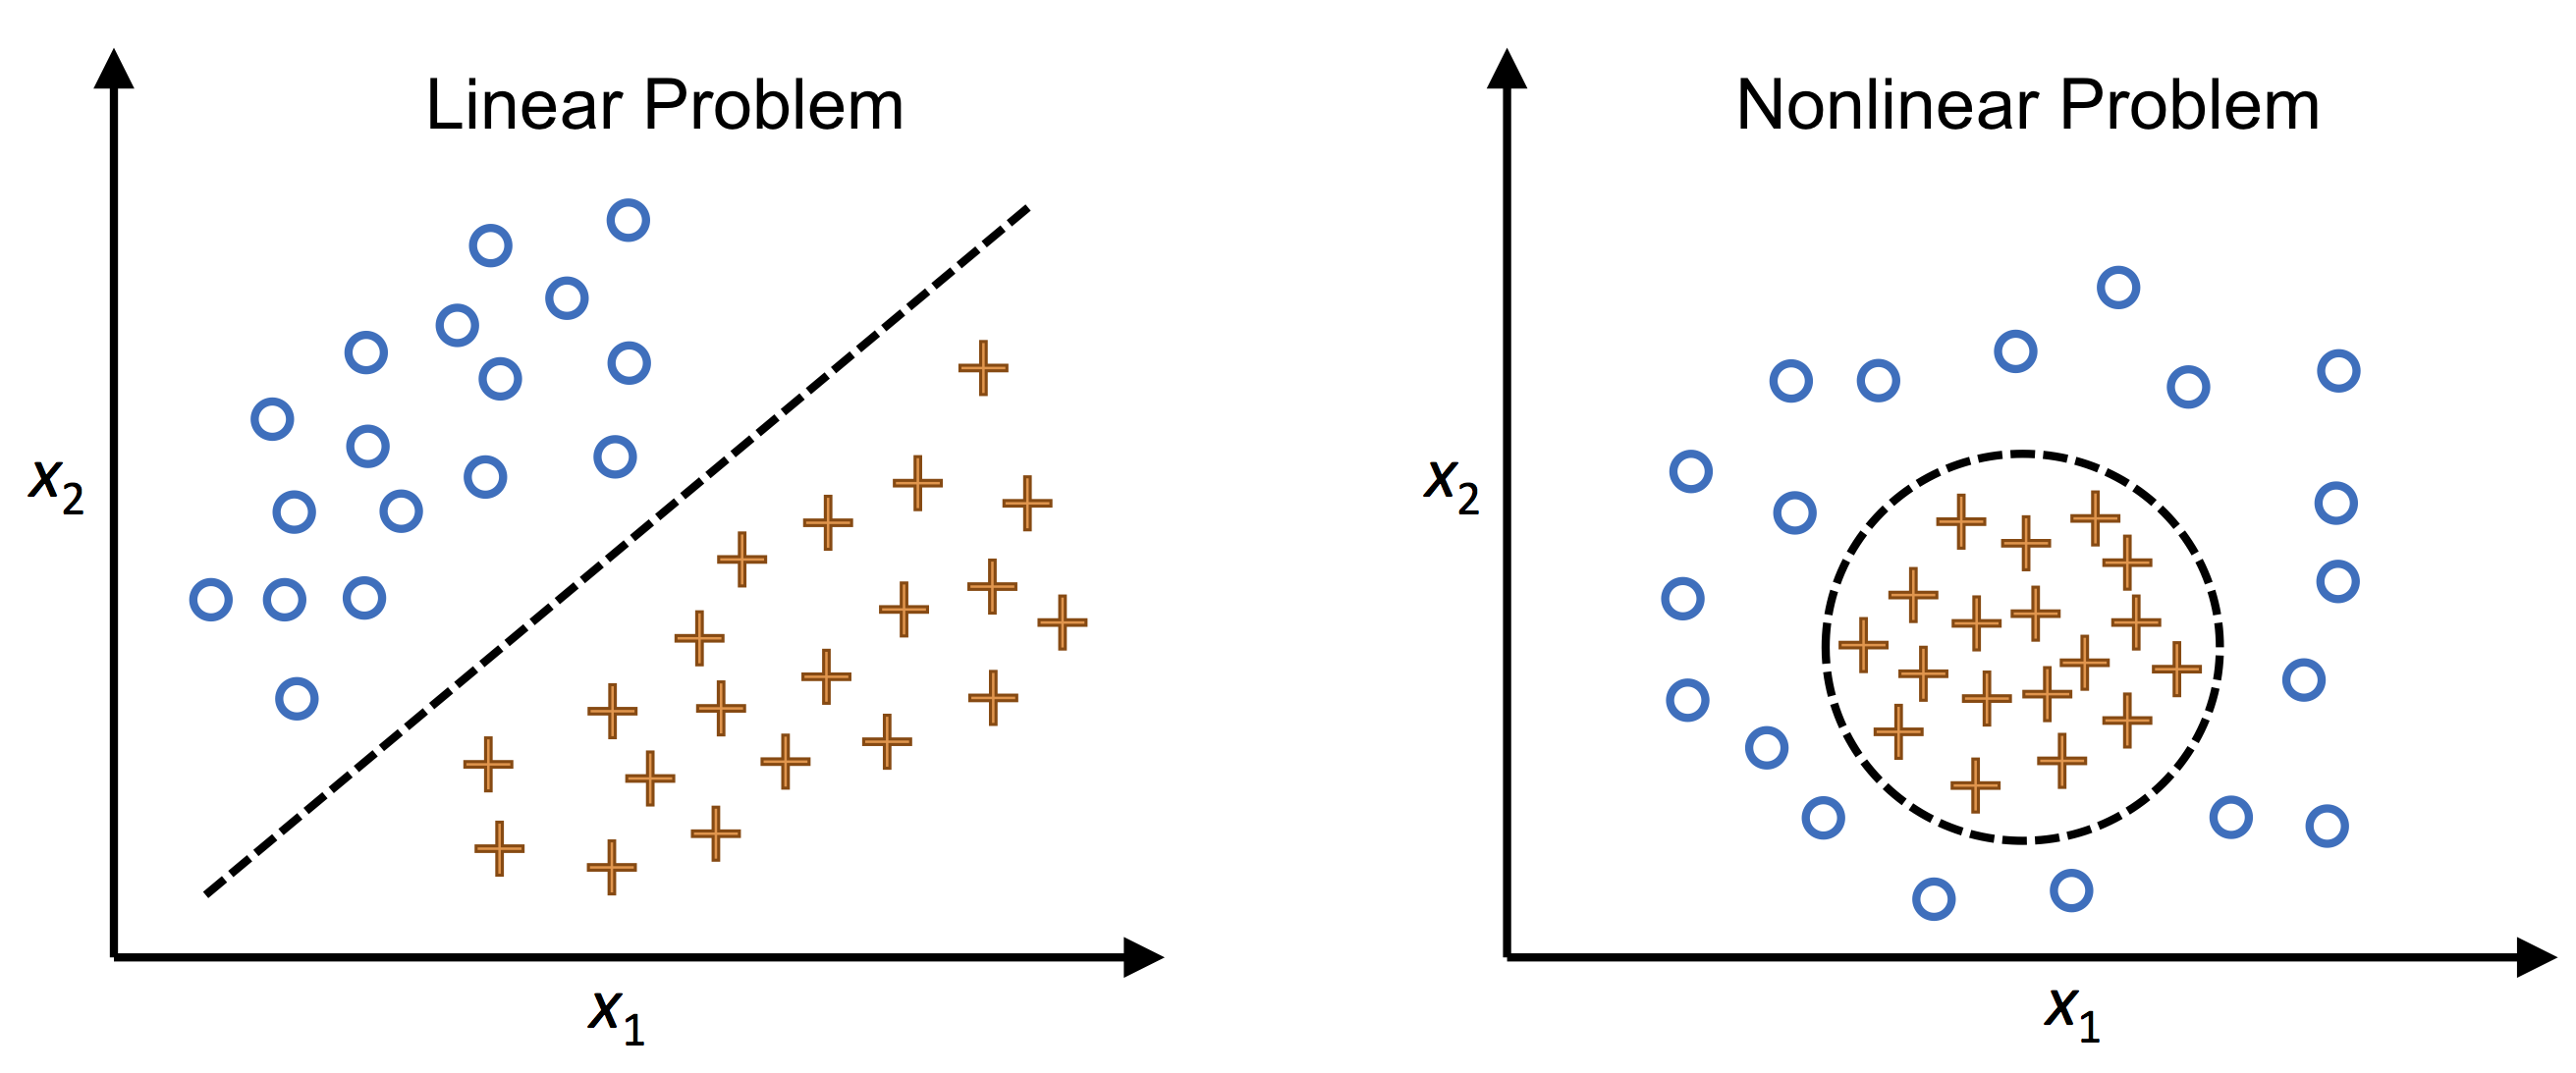

In [61]:
Image(filename='images/05_11.png', width=500) 

$$\phi: R^{d} \to R^{k} \ \ (k>>d)$$

We can think of 𝜙 as a function that creates nonlinear combinations of the original
features to map the original d-dimensional dataset onto a larger, k-dimensional
feature space.

$$x = [x_{1}, x_{2}]^{T}$$

$$\downarrow \phi$$

$$z = [x_{1}^{2}, \sqrt{2x_{1}x_{2}}, x_{2}^2]^{T}$$

$$\sigma_{jk} = \frac{1}{n}\sum_{i=1}^{n}\left(x_{j}^{(i)}-\mu_{j}\right)\left(x_{k}^{(i)}-\mu_{k}\right)$$

$$\sigma_{jk} = \frac{1}{n}\sum_{i=1}^{n}x_{j}^{(i)}x_{k}^{(i)}$$

$$\Sigma = \frac{1}{n}\sum_{i=1}^{n} x^{(i)}x^{(i)^{T}}$$

$$\Sigma = \frac{1}{n}\sum_{i=1}^{n} \phi(x^{(i)}) \phi \left( x^{(i)} \right)^{T}$$

$$\Sigma v = \lambda v$$

$$\implies \frac{1}{n}\sum_{i=1}^{n} \phi(x^{(i)}) \phi \left( x^{(i)} \right)^{T} v = \lambda v$$

$$\implies v = \frac{1}{\lambda n}\sum_{i=1}^{n} \phi(x^{(i)}) \phi \left( x^{(i)} \right)^{T} v
             = \frac{1}{ n}\sum_{i=1}^{n} a^{(i)} \phi \left( x^{(i)} \right)$$

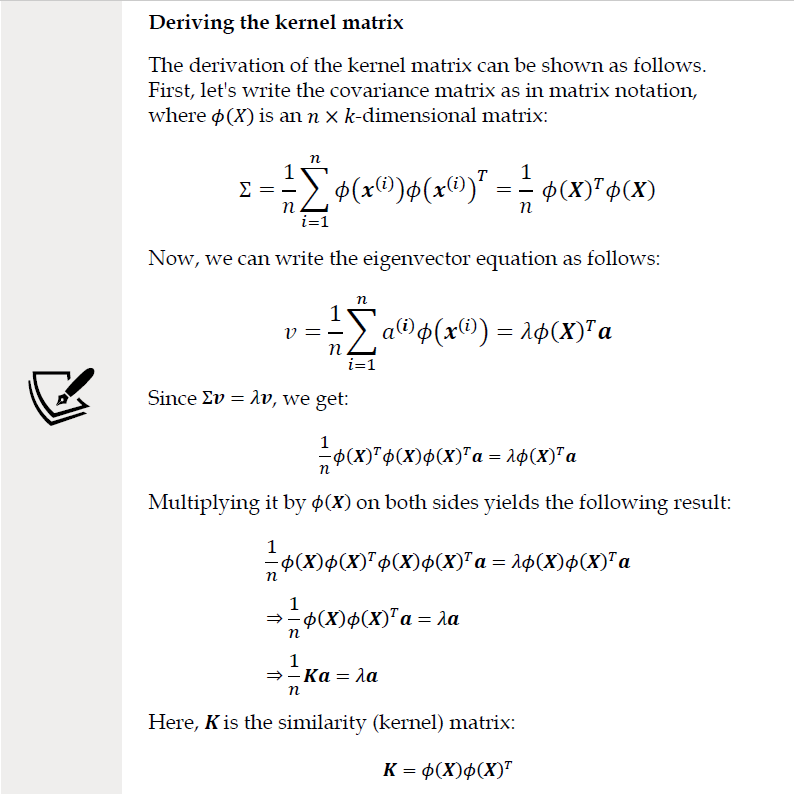

In [62]:
Image(filename='images/05_20.png', width=500) 

$$\kappa\left(x^{(i)}, x^{(j)}\right) =  \phi \left(x^{(i)}\right)^{T} \phi \left( x^{(j)} \right)$$

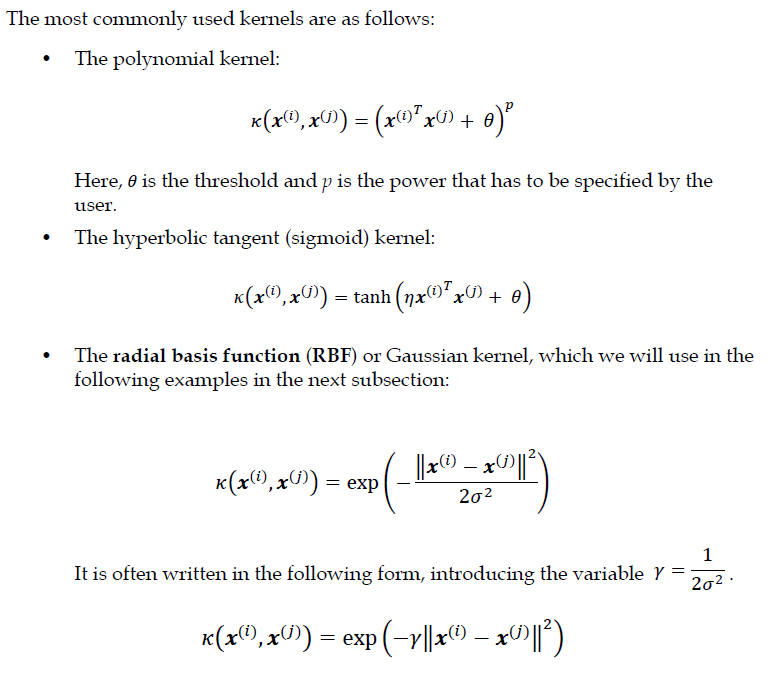

In [63]:
Image(filename='images/05_21.png', width=500) 

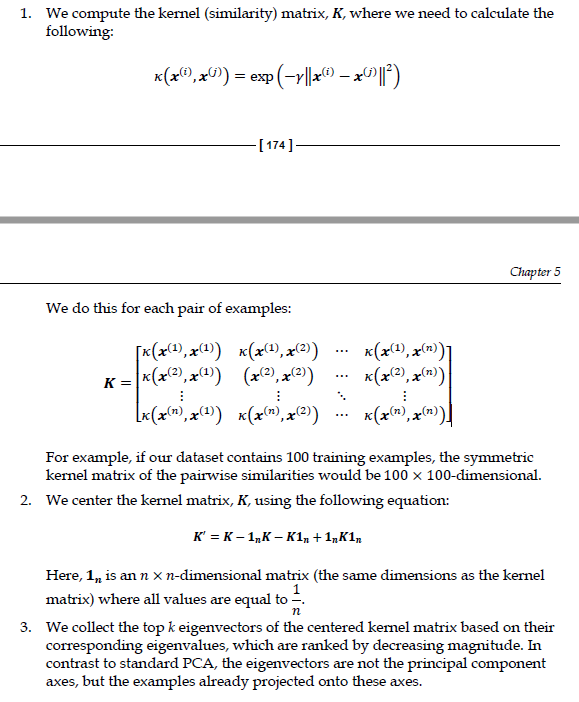

In [64]:
Image(filename='images/05_22.png', width=500) 

<br>
<br>

## Implementing a kernel principal component analysis in Python

In [65]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp




def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

In [66]:
pdist?

In [67]:
squareform?

In [68]:
np.column_stack?

<br>

### Example 1: Separating half-moon shapes

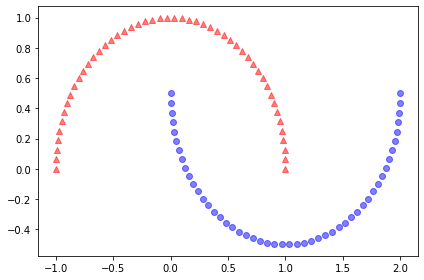

In [69]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()

In [70]:
make_moons?

In [71]:
y

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int64)

In [72]:
X.mean(axis=0)

array([0.5 , 0.25])

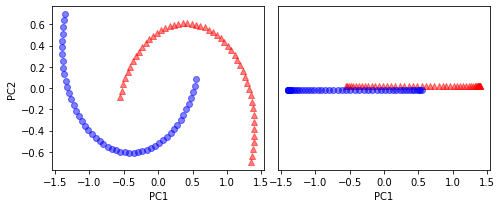

In [73]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

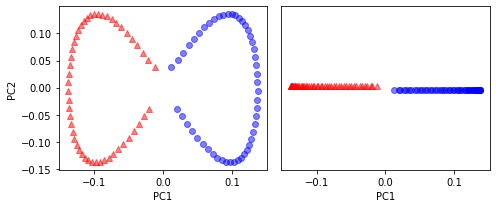

In [74]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show() # 跟最後使用 scikitlearn 差一個倍數，須注意，這裡可能有錯!

gamma=  1


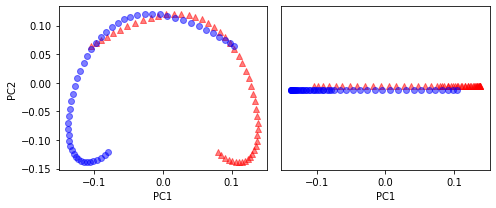

gamma=  2


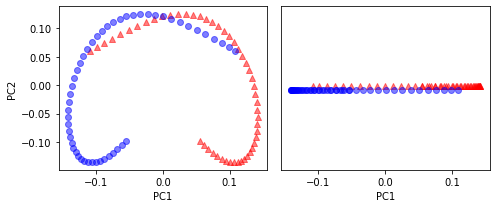

gamma=  3


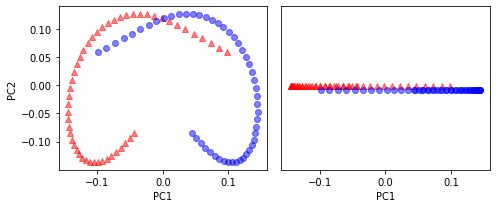

gamma=  4


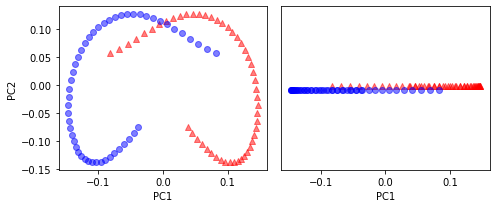

gamma=  5


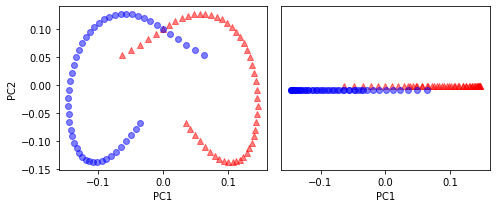

gamma=  6


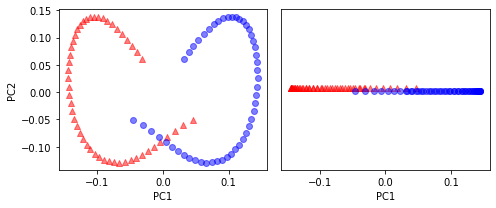

gamma=  7


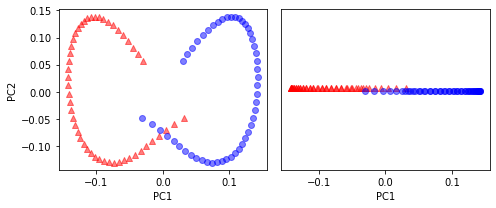

gamma=  8


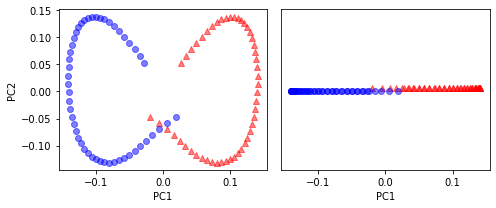

gamma=  9


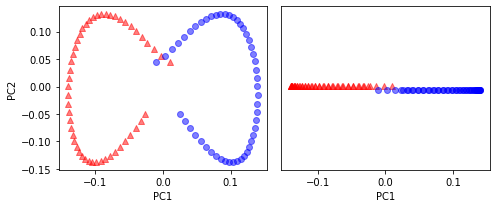

gamma=  10


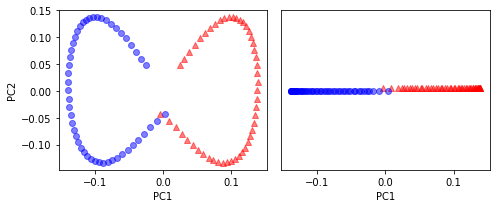

gamma=  11


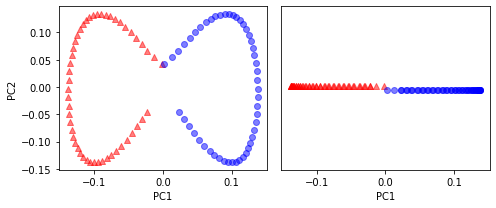

gamma=  12


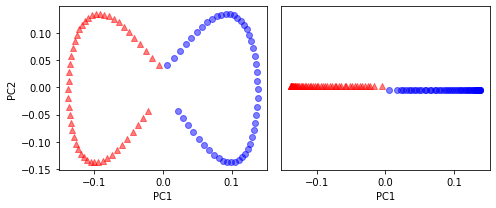

gamma=  13


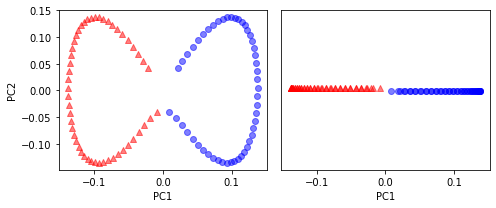

gamma=  14


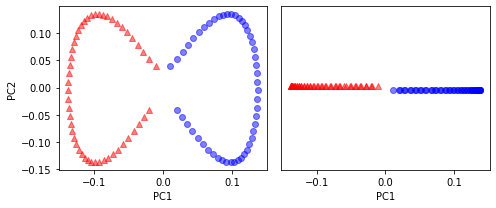

gamma=  15


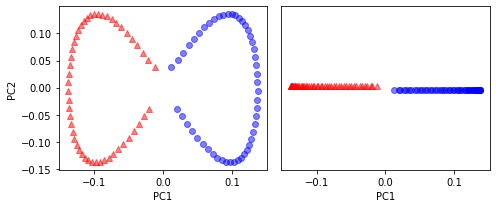

gamma=  16


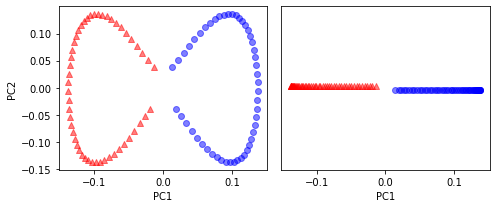

gamma=  17


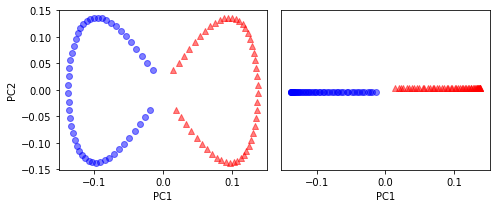

gamma=  18


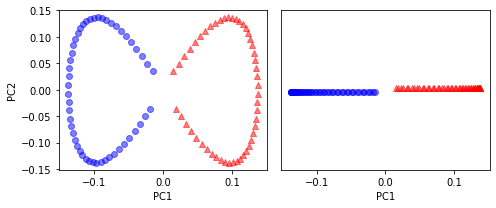

gamma=  19


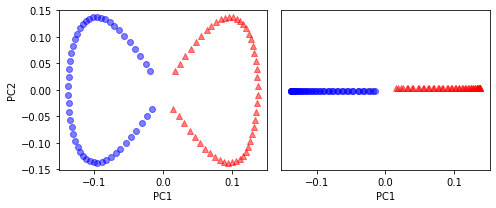

gamma=  20


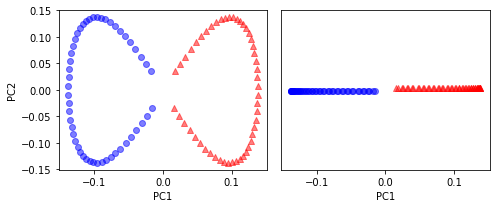

gamma=  21


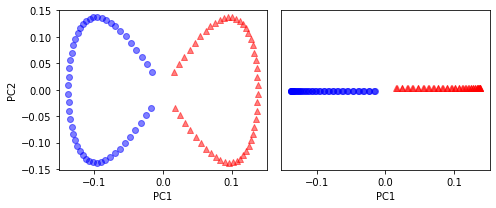

gamma=  22


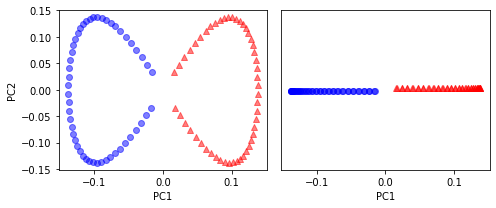

gamma=  23


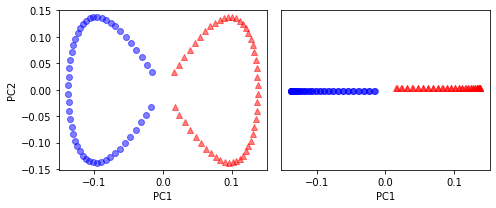

gamma=  24


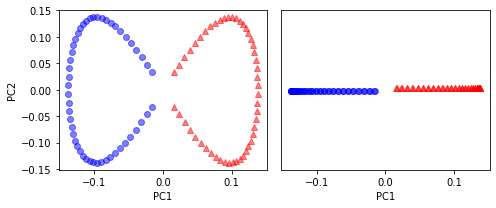

gamma=  25


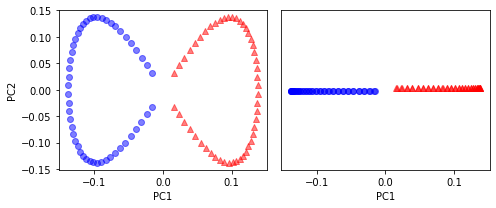

gamma=  26


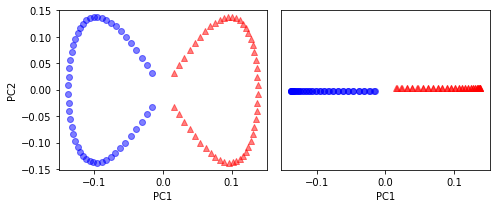

gamma=  27


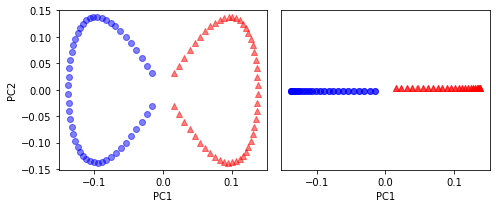

gamma=  28


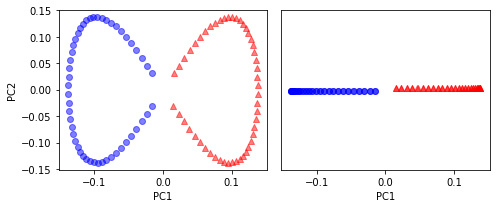

gamma=  29


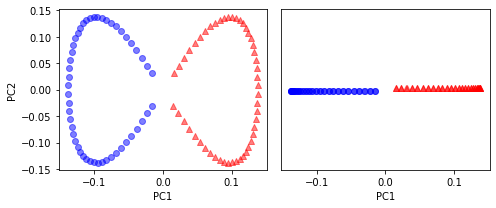

gamma=  30


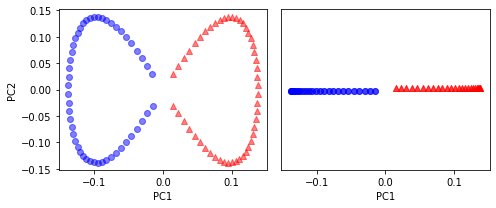

In [75]:
for i in range(1, 31):
    print("gamma= ", i) 
    X_kpca = rbf_kernel_pca(X, gamma=i, n_components=2)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
    ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
                color='red', marker='^', alpha=0.5)
    ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
                color='blue', marker='o', alpha=0.5)

    ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
                color='red', marker='^', alpha=0.5)
    ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
                color='blue', marker='o', alpha=0.5)

    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_ylim([-1, 1])
    ax[1].set_yticks([])
    ax[1].set_xlabel('PC1')

    plt.tight_layout()
    # plt.savefig('images/05_14.png', dpi=300)
    plt.show()

<br>

### Example 2: Separating concentric circles

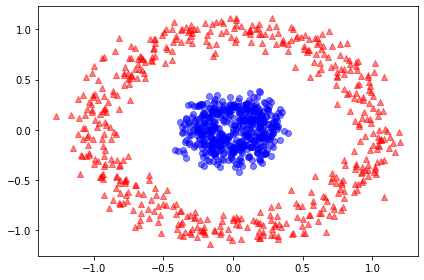

In [76]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

In [77]:
make_circles?

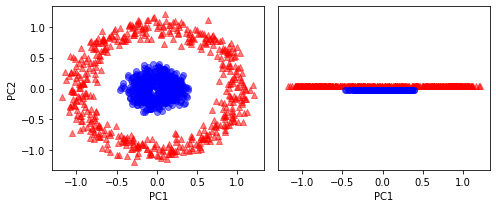

In [78]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

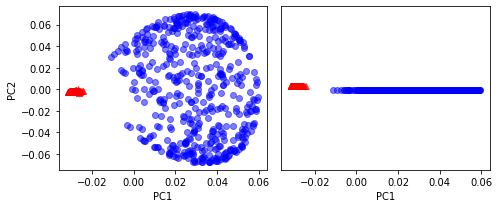

In [79]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

gamma=  1


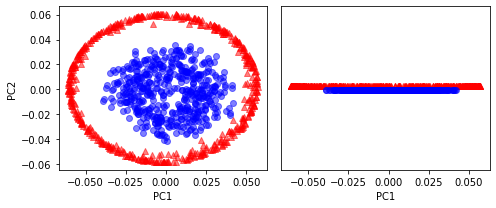

gamma=  2


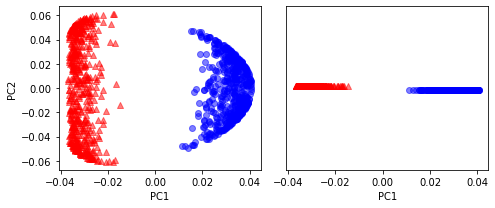

gamma=  3


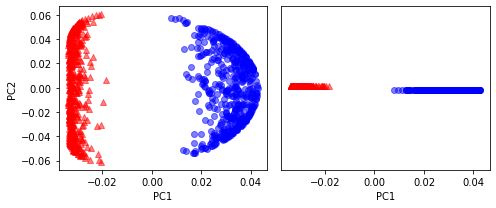

gamma=  4


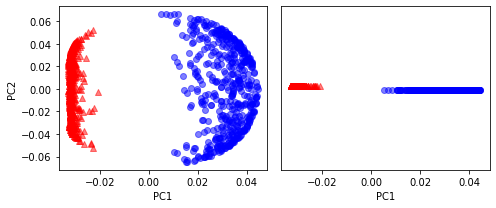

gamma=  5


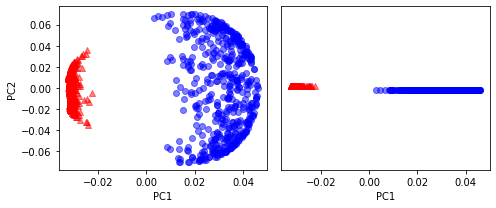

gamma=  6


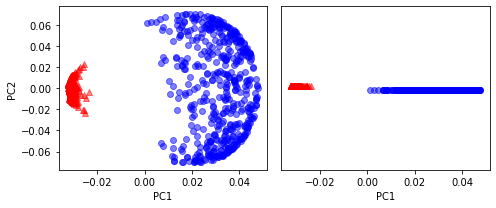

gamma=  7


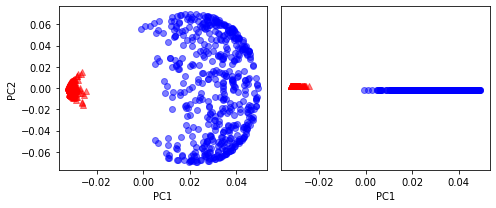

gamma=  8


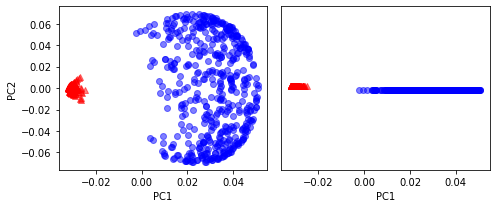

gamma=  9


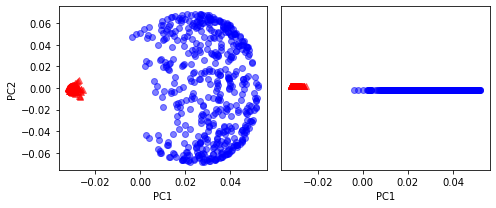

gamma=  10


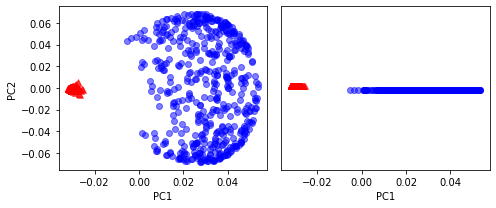

gamma=  11


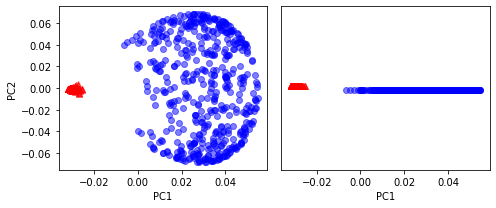

gamma=  12


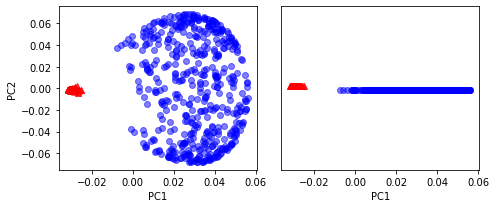

gamma=  13


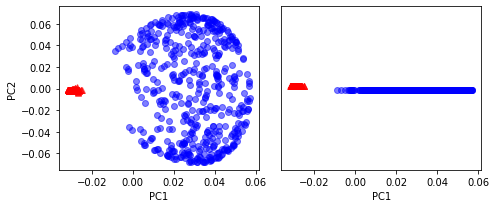

gamma=  14


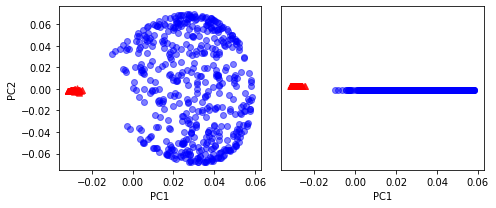

gamma=  15


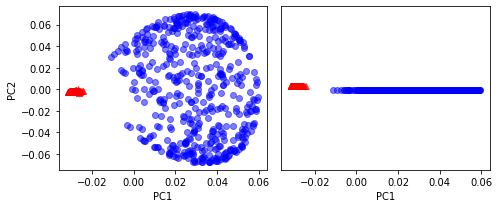

gamma=  16


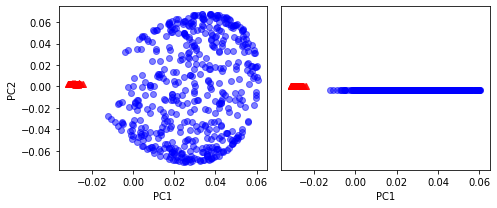

gamma=  17


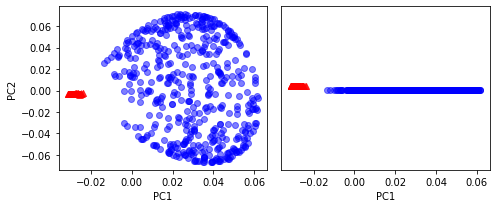

gamma=  18


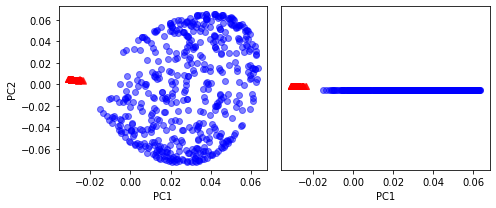

gamma=  19


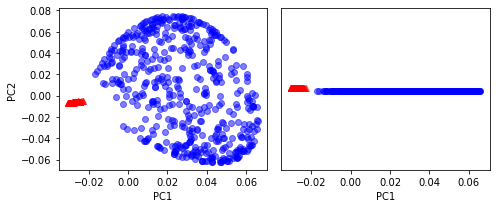

gamma=  20


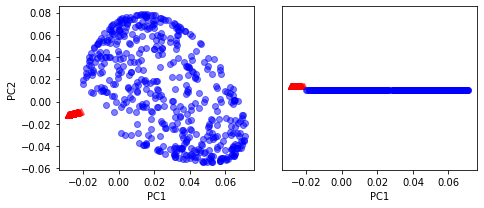

gamma=  21


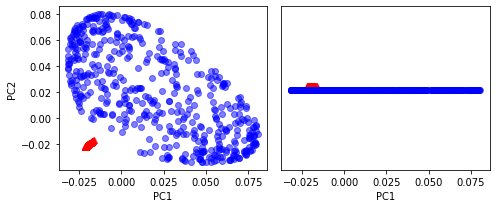

gamma=  22


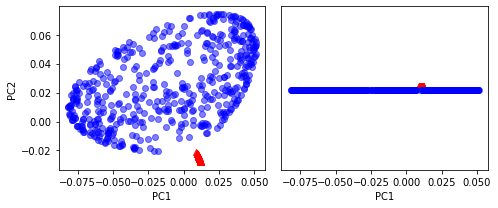

gamma=  23


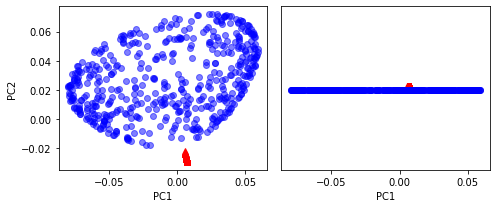

gamma=  24


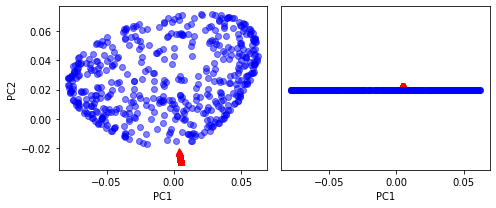

gamma=  25


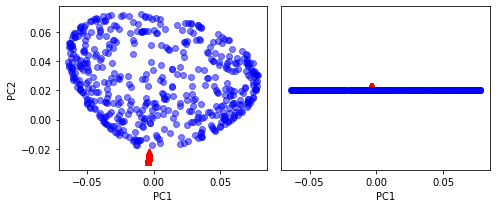

gamma=  26


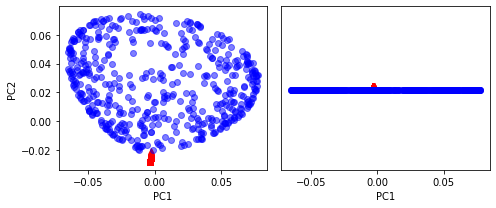

gamma=  27


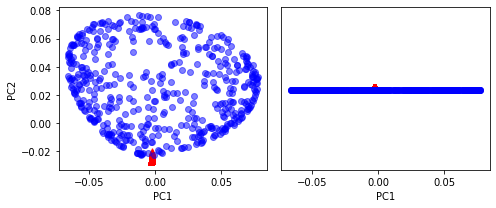

gamma=  28


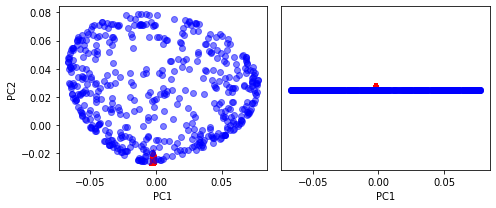

gamma=  29


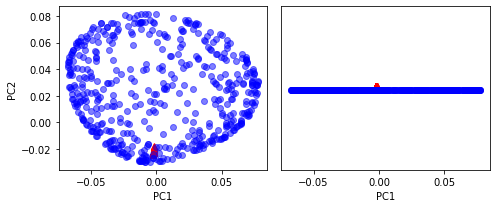

gamma=  30


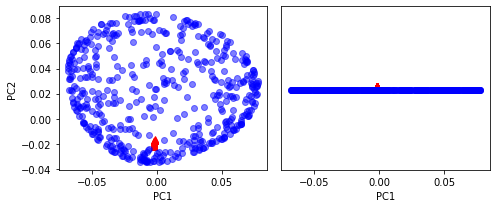

In [80]:
for i in range(1, 31):
    print("gamma= ", i) 
    X_kpca = rbf_kernel_pca(X, gamma=i, n_components=2)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
    ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
                  color='red', marker='^', alpha=0.5)
    ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
                  color='blue', marker='o', alpha=0.5)

    ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
                  color='red', marker='^', alpha=0.5)
    ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
                  color='blue', marker='o', alpha=0.5)

    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[1].set_ylim([-1, 1])
    ax[1].set_yticks([])
    ax[1].set_xlabel('PC1')

    plt.tight_layout()
    # plt.savefig('images/05_17.png', dpi=300)
    plt.show()

<br>
<br>

## Projecting new data points

In [81]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     alphas: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset 
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [82]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

<ipython-input-81-fecbb5490e48>:37: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)


In [83]:
alphas.shape

(100, 1)

In [84]:
alphas.T.dot(alphas)

array([[1.]])

In [85]:
lambdas

[7.062724756679958]

In [86]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [87]:
x_proj = alphas[25] # original projection
x_proj

array([0.0788])

In [88]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

---

In [89]:
alphas[:5]

array([[-0.0746],
       [ 0.1318],
       [ 0.1252],
       [-0.1349],
       [ 0.1052]])

In [90]:
# Maybe the correct projection is ...
alphas_ = alphas/(np.array(lambdas)**0.5)
alphas_[:5]

array([[-0.0281],
       [ 0.0496],
       [ 0.0471],
       [-0.0508],
       [ 0.0396]])

In [91]:
alphas_.T.dot(alphas_)

array([[0.1416]])

In [92]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas_)

# projection of the "new" datapoint
x_reproj_ = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj_ 

array([0.2093])

In [93]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)
X_skernpca[25]

array([0.2093])

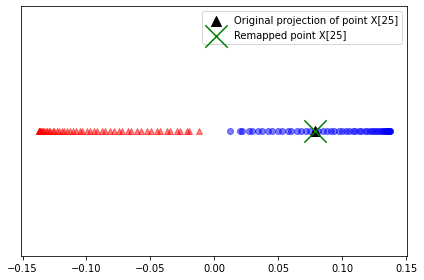

In [94]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Remapped point X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('images/05_18.png', dpi=300)
plt.show()

<br>
<br>

## Kernel principal component analysis in scikit-learn

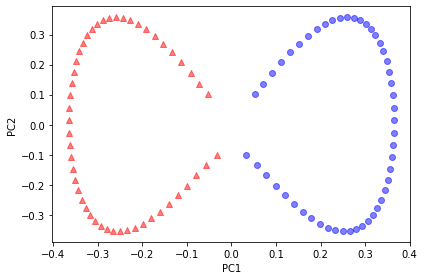

In [95]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()

In [96]:
X_skernpca[:3]

array([[-0.1981, -0.3289],
       [ 0.3504, -0.1836],
       [ 0.3328,  0.273 ]])

In [97]:
X[:3]

array([[ 0.8713,  0.4907],
       [ 0.7155, -0.4587],
       [ 1.4625, -0.3866]])

In [98]:
scikit_kpca.transform([[0.8713,  0.4907]])

array([[-0.1981, -0.3289]])

<br>
<br>

# Summary

...

---

Readers may ignore the next cell.

In [99]:
! python ../.convert_notebook_to_script.py --input ch05.ipynb --output ch05.py

python: can't open file '../.convert_notebook_to_script.py': [Errno 2] No such file or directory
